### 人臉偵測、對齊、裁切與統一像素

##### 匯入套件

In [1]:
%run C:\Users\user\Desktop\ICO_face\preamble.ipynb
import itertools
from tensorflow.keras.models import load_model
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler

【日期時間】2022/12/01 12:08:45
【工作目錄】c:\Users\user\Desktop\ICO_face
【主機名稱】DESKTOP-AHINHHC (10.131.70.20)
【程式版本】3.9.5


Autosaving every 120 seconds


#### 定義function

##### 	<font color=blue>關鍵68個點找尋</font>

In [2]:
def visualize_landmark(image_array, landmarks):
    """ plot landmarks on image
    :param image_array: numpy array of a single image
    :param landmarks: dict of landmarks for facial parts as keys and tuple of coordinates as values
    :return: plots of images with landmarks on
    """
    origin_img = Image.fromarray(image_array)
    draw = ImageDraw.Draw(origin_img)
    for facial_feature in landmarks.keys():
        draw.point(landmarks[facial_feature], fill = '#28FF28')
    imshow(origin_img)

##### 	<font color=blue>尋找中心點來旋轉</font>

In [3]:
def align_face(image_array, landmarks):
    """ align faces according to eyes position
    :param image_array: numpy array of a single image
    :param landmarks: dict of landmarks for facial parts as keys and tuple of coordinates as values
    :return:
    rotated_img:  numpy array of aligned image
    eye_center: tuple of coordinates for eye center
    angle: degrees of rotation
    """
    # get list landmarks of left and right eye
    left_eye = landmarks['left_eye']
    right_eye = landmarks['right_eye']
    # calculate the mean point of landmarks of left and right eye
    left_eye_center = np.mean(left_eye, axis = 0).astype("int")
    right_eye_center = np.mean(right_eye, axis = 0).astype("int")
    # compute the angle between the eye centroids
    dy = right_eye_center[1] - left_eye_center[1]
    dx = right_eye_center[0] - left_eye_center[0]
    # compute angle between the line of 2 centeroids and the horizontal line
    angle = math.atan2(dy, dx) * 180. / math.pi
    # calculate the center of 2 eyes
    eye_center = ((left_eye_center[0] + right_eye_center[0]) // 2,
                  (left_eye_center[1] + right_eye_center[1]) // 2)
    # at the eye_center, rotate the image by the angle
    rotate_matrix = cv2.getRotationMatrix2D((int(eye_center[0]), int(eye_center[1])), angle, scale = 1)
    #center必須要整數
    rotated_img = cv2.warpAffine(image_array, rotate_matrix, (image_array.shape[1], image_array.shape[0]))
    return rotated_img, eye_center, angle

##### 	<font color=blue>將座標旋轉，因原點不同，轉換上要特別處理</font>

In [4]:
def rotate(origin, point, angle, row):
    """ rotate coordinates in image coordinate system
    :param origin: tuple of coordinates,the rotation center
    :param point: tuple of coordinates, points to rotate
    :param angle: degrees of rotation
    :param row: row size of the image
    :return: rotated coordinates of point
    """
    x1, y1 = point
    x2, y2 = origin
    y1 = row - y1
    y2 = row - y2
    angle = math.radians(angle)
    x = x2 + math.cos(angle) * (x1 - x2) - math.sin(angle) * (y1 - y2)
    y = y2 + math.sin(angle) * (x1 - x2) + math.cos(angle) * (y1 - y2)
    y = row - y
    return int(x), int(y)

##### 	<font color=blue>以雙眼中心為原點旋轉$\theta$角度</font>

In [5]:
def rotate_landmarks(landmarks, eye_center, angle, row):
    """ rotate landmarks to fit the aligned face
    :param landmarks: dict of landmarks for facial parts as keys and tuple of coordinates as values
    :param eye_center: tuple of coordinates for eye center
    :param angle: degrees of rotation
    :param row: row size of the image
    :return: rotated_landmarks with the same structure with landmarks, but different values
    """
    rotated_landmarks = defaultdict(list)
    for facial_feature in landmarks.keys():
        for landmark in landmarks[facial_feature]:
            rotated_landmark = rotate(origin = eye_center, point = landmark, angle = angle, row = row)
            rotated_landmarks[facial_feature].append(rotated_landmark)
    return rotated_landmarks

##### 	<font color=blue>定義裁切函數</font>

##### 垂直方向上分為三部分
- 中部：兩眼landmark中心到嘴巴landmark中心的像素距離，占垂直方向的35%
- 底部：占垂直方向的35%
- 頂部：占垂直方向的30% 水平方向以最靠左和最靠右的landmark的中點為裁剪後圖片的中心點，crop 區域 w = h

In [6]:
def corp_face(image_array, landmarks):
    """ crop face according to eye,mouth and chin position
    :param image_array: numpy array of a single image
    :param landmarks: dict of landmarks for facial parts as keys and tuple of coordinates as values
    :return:
    cropped_img: numpy array of cropped image
    """

    eye_landmark = np.concatenate([np.array(landmarks['left_eye']),
                                   np.array(landmarks['right_eye'])])
    eye_center = np.mean(eye_landmark, axis = 0).astype('int')
    lip_landmark = np.concatenate([np.array(landmarks['top_lip']),
                                   np.array(landmarks['bottom_lip'])])
    lip_center = np.mean(lip_landmark, axis = 0).astype('int')
    mid_part = lip_center[1] - eye_center[1]
    top = 1.2*(eye_center[1] - mid_part * 30 / 15)  # 35
    bottom = 1.1*(lip_center[1] + mid_part)

    w = h = bottom - top
    x_min = np.min(landmarks['chin'], axis = 0)[0]
    x_max = np.max(landmarks['chin'], axis = 0)[0]
    x_center = (x_max - x_min) / 2 + x_min
    left, right = (x_center - w / 2, x_center + w / 2)

    pil_img = Image.fromarray(image_array)
    left, top, right, bottom = [int(i) for i in [left, top, right, bottom]]
    cropped_img = pil_img.crop((left, top, right, bottom))
    cropped_img = np.array(cropped_img)
    return cropped_img, left, top

##### 	<font color=blue>去背景函數</font>

In [7]:
def chop_back(img):
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor(path_land)
    rect = detector(img)[0]
    sp = predictor(img, rect)
    landmarks = np.array([[p.x, p.y] for p in sp.parts()])
    outline = landmarks[[*range(17), *range(26, 16, -1)]]
    Y, X = skimage.draw.polygon(outline[:,1], outline[:,0])
    cropped_img = np.ones(img.shape, dtype = np.uint8)*255
    cropped_img[Y, X] = img[Y, X]
    return Image.fromarray(cropped_img)
#matplotlib.image.imsave('E:/test20210810.png',cropped_img)

##### 	<font color=blue>65個變數計算需要的函數(幾何類計算)</font>

In [8]:
# 多變形面積計算
def PolyArea(x,y):
    return 0.5*np.abs(np.dot(x,np.roll(y,1)) - np.dot(y,np.roll(x,1)))

# 質心計算
def centeroidnp(x):
    arr = landmarks[x]
    length = arr.shape[0]
    sum_x = np.sum(arr[:, 0])
    sum_y = np.sum(arr[:, 1])
    return sum_x/length, sum_y/length

# 距離(v_h:0 = horizontal, 1 = vertical)
def distance_ca(y1,y2,v_h):
    x1 = landmarks[y1]
    x2 = landmarks[y2]
    length1 = x1.shape[0]
    length2 = x2.shape[0]
    sum1 = np.sum(x1[:, v_h])
    sum2 = np.sum(x2[:, v_h])
    dis = abs(sum1/length1 - sum2/length2)
    return dis

# 計算回歸係數
def grad_ca(arr):
    x = np.array(list(zip(*landmarks[arr]))[0]).reshape([-1, 1])
    y = np.array(list(zip(*landmarks[arr]))[1])
    model = LinearRegression().fit(x, y)    # sklearn.linear_model
    return model.coef_[0]

# 計算x^2回歸係數
def gradx2_ca(arr):
    x = np.array(list(zip(*landmarks[arr]))[0]).reshape([-1, 1])
    y = np.array(list(zip(*landmarks[arr]))[1])
    x_ = PolynomialFeatures(degree=2, include_bias = False).fit_transform(x)
    model = LinearRegression().fit(x_, y)   # sklearn.linear_model
    return model.coef_[1]

##### 	<font color=blue>65個變數計算需要的函數(RGB,HSV計算)</font>

In [9]:
import colorsys
import PIL.Image as Image
 
def get_dominant_color(image):
    max_score = 0.0001
    dominant_color = None
    for count,(r,g,b) in image.getcolors(image.size[0]*image.size[1]):
        # 轉為HSV標準
        saturation = colorsys.rgb_to_hsv(r/255.0, g/255.0, b/255.0)[1]
        y = min(abs(r*2104+g*4130+b*802+4096+131072)>>13,235)
        y = (y-16.0)/(235-16)
    #忽略高亮色
        if y > 0.9:
            continue
        score = (saturation+0.1)*count
        if score > max_score:
            max_score = score
            dominant_color = [r,g,b]
    return colorsys.rgb_to_hsv(dominant_color[0],dominant_color[1],dominant_color[2])


def chop_area(img, outline):
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor(path_land)
    rect = detector(img)[0]
    sp = predictor(img, rect)
    landmarks = np.array([[p.x, p.y] for p in sp.parts()])
    #outline = landmarks[[*range(17), *range(26,16,-1)]]
    Y, X = skimage.draw.polygon(outline[:,1], outline[:,0])
    cropped_img = np.ones(aaa.shape, dtype=np.uint8)*255
    cropped_img[Y, X] = img[Y, X]
    return Image.fromarray(cropped_img)

##### 	<font color=blue>65個變數計算需要的函數(entropy計算)</font>

In [10]:
def get_entropy_color(image):
    max_score = 0.0001
    dominant_color = None
    h_dist=[]
    s_dist=[]
    v_dist=[]
    for count,(r,g,b) in image.getcolors(image.size[0]*image.size[1]):
        # GRB to HSV
        saturation = colorsys.rgb_to_hsv(r, g, b)
    #忽略高亮色
        if r + g + b < 750:
            h_dist = h_dist + [saturation[0]]
            s_dist = s_dist + [saturation[1]]
            v_dist = v_dist + [saturation[2]]
    return h_dist, s_dist, v_dist


def hist_entropy(h):
    hist_h = np.histogram(h, bins=50)
    hist_h = list(hist_h[0])
    hist_h = [h/float(sum(hist_h)) for h in hist_h]
    entropy_h = entropy(hist_h)
    return entropy_h
# https://vimsky.com/examples/detail/python-ex-scipy.stats---entropy-function.html

##### 	<font color=blue>append_df_to_excel</font>

In [11]:
def append_df_to_excel(filename, df, sheet_name='Sheet1', startrow=None,
                       truncate_sheet=False, 
                       **to_excel_kwargs):
    if not os.path.isfile(filename):
        df.to_excel(
            filename,
            sheet_name=sheet_name, 
            startrow=startrow if startrow is not None else 0, 
            **to_excel_kwargs)
        return
    if 'engine' in to_excel_kwargs:
        to_excel_kwargs.pop('engine')
    writer = pd.ExcelWriter(filename, engine='openpyxl', mode='a', if_sheet_exists = 'overlay')    # if_sheet_exists = 'overlay' 可去除或用 replace
    writer.book = load_workbook(filename)
    if startrow is None and sheet_name in writer.book.sheetnames:
        startrow = writer.book[sheet_name].max_row
    if truncate_sheet and sheet_name in writer.book.sheetnames:
        idx = writer.book.sheetnames.index(sheet_name)
        writer.book.remove(writer.book.worksheets[idx])
        writer.book.create_sheet(sheet_name, idx)
    writer.sheets = {ws.title:ws for ws in writer.book.worksheets}
    if startrow is None:
        startrow = 0
    df.to_excel(writer, sheet_name, startrow=startrow, **to_excel_kwargs)
    writer.save()
    
def my_mode(sample):
    c = Counter(sample)
    return [k for k, v in c.items() if v == c.most_common(1)[0][1]]

#### 範例演示

##### 	<font color=blue>前處理(匯入、旋轉和裁切)</font>

In [14]:
img_name = r"C:\Users\user\Desktop\founder_photo2\BAT.jpg"    # r"E:\thesis\main_data\photo\KHC.jpg"#路徑不能有中文'AVY_1
image_array = cv2.imread(img_name)
image_array = cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)
# Image.fromarray(image_array)

In [15]:
# 尋找68個點
face_landmarks_list = face_recognition.face_landmarks(image_array, model = "large")
face_landmarks_dict = face_landmarks_list[0]
print(face_landmarks_dict, end = " ")

{'chin': [(750, 801), (753, 914), (757, 1026), (769, 1138), (808, 1235), (870, 1320), (957, 1390), (1057, 1432), (1169, 1443), (1274, 1424), (1360, 1376), (1436, 1303), (1490, 1216), (1525, 1114), (1541, 1008), (1560, 901), (1577, 792)], 'left_eyebrow': [(834, 744), (885, 688), (967, 669), (1049, 681), (1128, 705)], 'right_eyebrow': [(1238, 701), (1307, 678), (1387, 669), (1463, 682), (1516, 728)], 'nose_bridge': [(1171, 754), (1168, 824), (1166, 893), (1164, 966)], 'nose_tip': [(1060, 1005), (1108, 1016), (1159, 1029), (1210, 1013), (1260, 998)], 'left_eye': [(923, 776), (970, 761), (1015, 760), (1062, 782), (1012, 783), (966, 783)], 'right_eye': [(1280, 775), (1329, 750), (1377, 750), (1423, 762), (1379, 772), (1329, 773)], 'top_lip': [(967, 1116), (1043, 1109), (1110, 1104), (1159, 1110), (1206, 1100), (1276, 1098), (1346, 1101), (1323, 1109), (1207, 1117), (1160, 1125), (1110, 1122), (988, 1121)], 'bottom_lip': [(1346, 1101), (1286, 1174), (1219, 1207), (1169, 1216), (1117, 1213), 

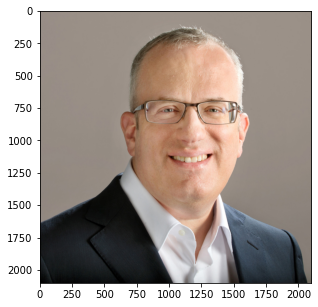

In [16]:
# 尋找68個點標註在照片上
plt.rcParams["figure.figsize"] = (5, 5)
visualize_landmark(image_array = image_array, landmarks = face_landmarks_dict)

In [17]:
# 以兩眼睛中心點為旋轉中點
aligned_face, eye_center, angle = align_face(image_array = image_array, landmarks = face_landmarks_dict)

In [18]:
print(face_landmarks_dict, end = " ")

{'chin': [(750, 801), (753, 914), (757, 1026), (769, 1138), (808, 1235), (870, 1320), (957, 1390), (1057, 1432), (1169, 1443), (1274, 1424), (1360, 1376), (1436, 1303), (1490, 1216), (1525, 1114), (1541, 1008), (1560, 901), (1577, 792)], 'left_eyebrow': [(834, 744), (885, 688), (967, 669), (1049, 681), (1128, 705)], 'right_eyebrow': [(1238, 701), (1307, 678), (1387, 669), (1463, 682), (1516, 728)], 'nose_bridge': [(1171, 754), (1168, 824), (1166, 893), (1164, 966)], 'nose_tip': [(1060, 1005), (1108, 1016), (1159, 1029), (1210, 1013), (1260, 998)], 'left_eye': [(923, 776), (970, 761), (1015, 760), (1062, 782), (1012, 783), (966, 783)], 'right_eye': [(1280, 775), (1329, 750), (1377, 750), (1423, 762), (1379, 772), (1329, 773)], 'top_lip': [(967, 1116), (1043, 1109), (1110, 1104), (1159, 1110), (1206, 1100), (1276, 1098), (1346, 1101), (1323, 1109), (1207, 1117), (1160, 1125), (1110, 1122), (988, 1121)], 'bottom_lip': [(1346, 1101), (1286, 1174), (1219, 1207), (1169, 1216), (1117, 1213), 

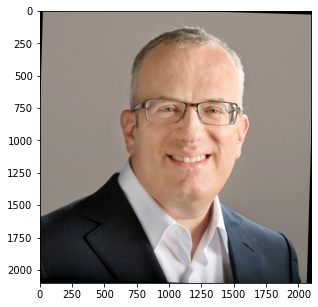

In [19]:
# 將原本找到的68個點也旋轉
rotated_landmarks = rotate_landmarks(landmarks = face_landmarks_dict,
                                         eye_center = eye_center, angle = angle, row = image_array.shape[0])
visualize_landmark(image_array = aligned_face, landmarks = rotated_landmarks)
plt.show()

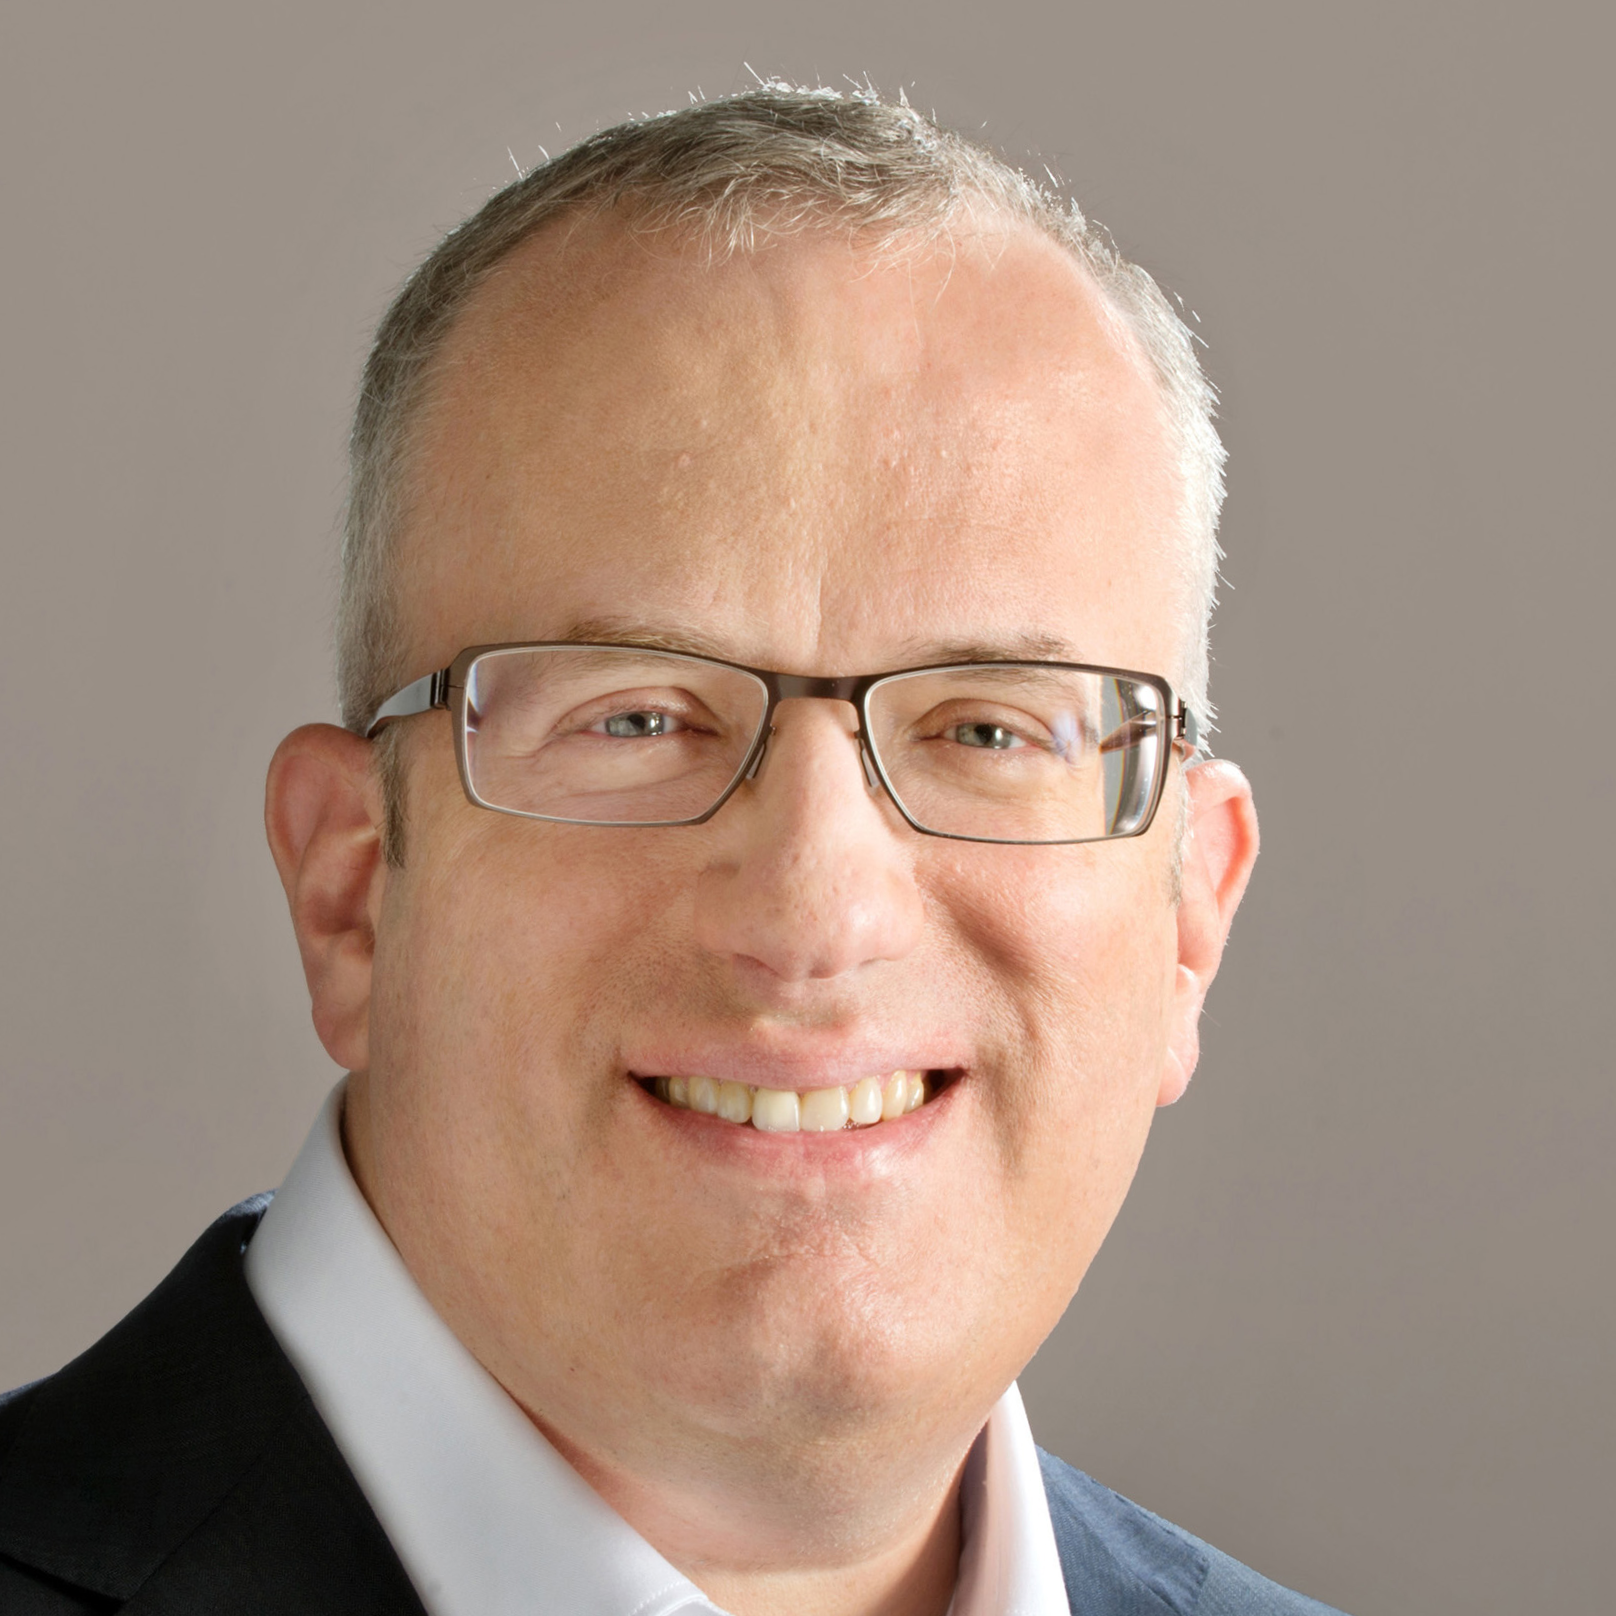

In [20]:
# 裁切臉部
cropped_img, left, top = corp_face(image_array = aligned_face, landmarks = rotated_landmarks)
# a = Image.fromarray(cropped_img)
Image.fromarray(cropped_img)
# matplotlib.image.imsave('E:/name.png', cropped_img)

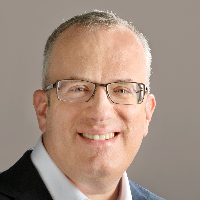

In [21]:
# 統一像素
aaa = cv2.resize(cropped_img, dsize = (200, 200), interpolation = cv2.INTER_CUBIC)
Image.fromarray(aaa)

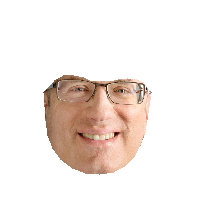

In [22]:
# 裁切臉部
chop_back(aaa)

In [23]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(path_land)
rect = detector(aaa)[0]
rect

rectangle(37,51,162,176)

##### 針對裁切(未去背景圖片)計算68個landmark再轉換至65個點。

In [24]:
aaa = cv2.resize(cropped_img, dsize=(200, 200), interpolation=cv2.INTER_CUBIC)
Image.fromarray(aaa)
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(path_land)
rect = detector(aaa)[0]
sp = predictor(aaa, rect)
landmarks = np.array([[p.x, p.y] for p in sp.parts()])

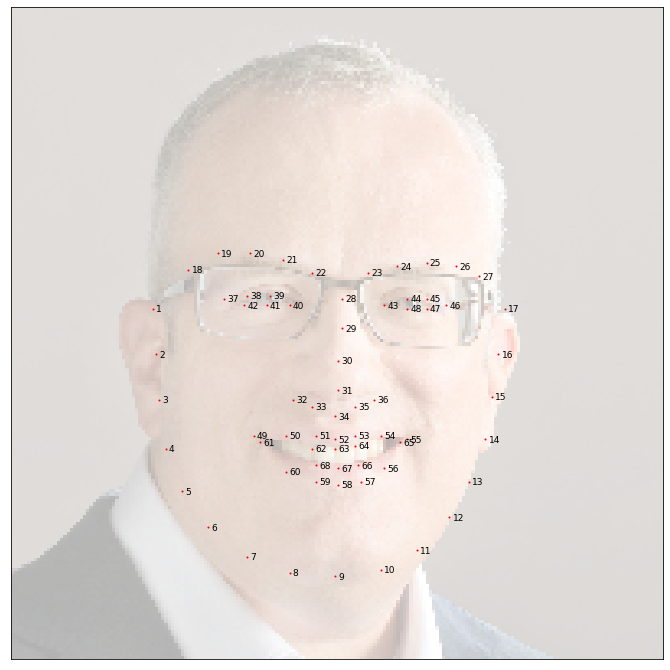

In [25]:
plt.rcParams["figure.figsize"] = (12, 12)
plt.imshow(aaa, alpha = 0.3)
plt.scatter(*zip(*landmarks), c = "red", s = 1)
for i in range(68):
    plt.annotate(str(i+1), (landmarks[i][0]+1, landmarks[i][1]+1), fontsize=9, color='black')
plt.xticks([])
plt.yticks([])
plt.show()

In [26]:
PolyArea(*zip(*landmarks[0:18], *landmarks[27:18]))

7882.5

#### 建立函數一次計算所有照片的65attr

##### 定義函數

In [27]:
def attr65_cal_fn(file):
    #讀取路徑照片
    path = os.getcwd()+file
    extensions = [r'.jpg', '.png', '.jpeg','.jfif']
    df = pd.DataFrame()
    global images
    images = [x for x in Path(path).iterdir() if x.suffix.lower() in extensions]
    indx = 0
    #尋找68點轉換成65臉部結構變數，並計算長寬比
    for i in images:
        #產生需要的index
        img_id = str(i).split('\\')[-1][:-4].strip('.')    
        img_id1 = img_id.split('_')[0]
        # year  = img_id.split('_')[1]
        print(indx,':',img_id)
        indx = indx+1
        #IMAGE RESIZE AND ROTATE
        image_array = cv2.imread(str(i))
        image_array = cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)
        face_landmarks_list = face_recognition.face_landmarks(image_array, model="large")
        face_landmarks_dict = face_landmarks_list[0]
        aligned_face, eye_center, angle = align_face(image_array=image_array, landmarks=face_landmarks_dict)
        rotated_landmarks = rotate_landmarks(landmarks=face_landmarks_dict,
                                         eye_center=eye_center, angle=angle, row=image_array.shape[0])
        cropped_img,left, top= corp_face(image_array=aligned_face, landmarks=rotated_landmarks)
        global aaa
        aaa = cv2.resize(cropped_img, dsize=(200, 200), interpolation=cv2.INTER_CUBIC)
        detector = dlib.get_frontal_face_detector()
        predictor = dlib.shape_predictor(path_land)
        rect = detector(aaa)[0]
        sp = predictor(aaa, rect)
        global landmarks
        #最終的68點輸出
        landmarks = np.array([[p.x, p.y] for p in sp.parts()])
        #計算65臉部特徵點
        att_01 = PolyArea(*zip(*landmarks[0:18], *landmarks[27:18]))
        att_02 = distance_ca(range(19,25),range(7,10),1)
        att_03 = distance_ca(range(15,17),range(0,2),0)
        tmp = centeroidnp(range(27,37))
        att_04 = tmp[0]
        att_05 = tmp[1]
        att_06 = 0
        att_07 = PolyArea(*zip(*landmarks[17:22])) + PolyArea(*zip(*landmarks[22:27]))
        att_08 = distance_ca([17,21,22,26],[18,19,20,23,24,25],1)
        att_09 = distance_ca([21], [26], 0) + distance_ca([17], [22], 0)
        att_10 = grad_ca(range(19,22))
        att_11 = PolyArea(*zip(*landmarks[36:42])) + PolyArea(*zip(*landmarks[42:48]))
        att_12 = PolyArea(*zip(*landmarks[37:42])) + PolyArea(*zip(*landmarks[43:48]))
        att_13 = distance_ca([40,41,46,47],[37,38,43,44],1)
        att_14 = distance_ca([39,45],[36,42],0)
        att_15 = att_12*1/np.pi/att_13**2
        att_16 = PolyArea(*zip(*landmarks[30:36]))+PolyArea(*zip(*landmarks[27:32]))+PolyArea(*zip(*landmarks[[27,30,35]]))
        att_17 = distance_ca([33],[27],1)
        att_18 = distance_ca([35],[31],0) 
        att_19 = gradx2_ca(range(31,36))
        att_20 = abs((np.array(centeroidnp([34,32]))-np.array(centeroidnp([31,35]))))[1] 
        att_21 = abs((np.array(centeroidnp([7,9]))-np.array(centeroidnp([2,14]))))[1]
        att_22 = grad_ca([6,7,8])+abs(grad_ca([8,9,10]))
        mjar   = np.mean(np.array(list(zip(*landmarks[2:15]))),1)
        att_23 = np.std(np.sqrt(np.sum((landmarks[2:15]-mjar)**2,1)))
        att_24 = abs(gradx2_ca(range(6,11)))
        att_25 = PolyArea(*zip(*landmarks[48:60]))
        att_26 = abs((np.array(centeroidnp(range(48,55)))-np.array(centeroidnp([55,56,57,58,59,48,54]))))[1]
        att_27 = abs((np.array(centeroidnp(range(48,55)))-np.array(centeroidnp([60, 61, 62, 63, 64, 48, 54]))))[1]
        att_28 = abs((np.array(centeroidnp([65,66,67,48,54]))-np.array(centeroidnp([55,56,57,58,59, 48, 54]))))[1]
        att_29 = abs((np.array(centeroidnp([48]))-np.array(centeroidnp([54]))))[0]
        att_30 = abs((np.array(centeroidnp([65,66,67,48,54]))-np.array(centeroidnp([60, 61, 62, 63, 48, 54]))))[0]
        att_31 = abs(gradx2_ca([60,61,62,63,48,54]))
        att_32 = abs(gradx2_ca([65,66,67,48,54]))
        att_33 = abs((np.array(centeroidnp([65,66,67,48,54]))-np.array(centeroidnp([60, 61, 62, 63, 48, 54]))))[0]
        att_34 = abs((np.array(centeroidnp([7,9]))-np.array(centeroidnp([2,3,31,48]))))[1]
        att_35 = abs(grad_ca([2,3,31,48]))
        tmp    = np.array(centeroidnp([27]))-np.array(centeroidnp([28,39]))
        att_36 = abs(tmp[1]/tmp[0])
        att_37 = abs((np.array(centeroidnp(range(7,10)))-np.array(centeroidnp(range(36,48)))))[1]/att_02
        att_38 = abs((np.array(centeroidnp(range(7,10)))-np.array(centeroidnp(range(17,26)))))[1]/att_02
        att_39 = abs((np.array(centeroidnp(range(7,10)))-np.array(centeroidnp(range(48,60)))))[1]/att_02
        att_40 = abs((np.array(centeroidnp(range(7,10)))-np.array(centeroidnp(range(27,36)))))[1]/att_02
        att_41 = abs((np.array(centeroidnp(range(37,42)))-np.array(centeroidnp(range(43,48)))))[0]
        att_42 = abs((np.array(centeroidnp([39,42]))-np.array(centeroidnp([50,52]))))[1]
        att_43 = abs((np.array(centeroidnp([17,21,22,26]))-np.array(centeroidnp([27,28,43,44]))))[1]
        att_44 = abs((np.array(centeroidnp([0,2]))-np.array(centeroidnp([36]))))[0]
        att_45 = abs((np.array(centeroidnp([14,16]))-np.array(centeroidnp([45]))))[0]
        att_46 = abs((np.array(centeroidnp([56,58]))-np.array(centeroidnp([7, 9]))))[1]
        att_47 = abs((np.array(centeroidnp([32,34]))-np.array(centeroidnp([50,51]))))[1]
        #att_48-att_62 = HSV calculation
        skin_area = chop_area(aaa,landmarks[[*range(17), *range(26,16,-1)]])
        image_skin = skin_area.convert("RGB")
        tmp = get_dominant_color(image_skin)
        att_48 = tmp[0]
        att_49 = tmp[1]
        att_50 = tmp[2]

        eyebrow_area = chop_area(aaa, landmarks[[*range(17,22,1), *range(22,27,1),22,21,17]])
        image_eyebrow = eyebrow_area.convert("RGB")
        tmp1 = get_dominant_color(image_eyebrow)

        att_51 = tmp1[0]
        att_52 = tmp1[1]
        att_53 = tmp1[2]

        lips_area = chop_area(aaa, landmarks[range(48,60)])
        image_lips = lips_area.convert("RGB")
        tmp2 = get_dominant_color(image_lips)

        att_54 = tmp2[0]
        att_55 = tmp2[1]
        att_56 = tmp2[2]

        eye_area = chop_area(aaa, landmarks[[40,41,37,38,40,47,43,44,46,47]])
        image_eye = eye_area.convert("RGB")
        tmp3 = get_dominant_color(image_eye)

        att_57 = tmp3[0]
        att_58 = tmp3[1]
        att_59 = tmp3[2]

        skin_area = chop_area(aaa,landmarks[[*range(17), *range(26,16,-1)]])
        skin_image = skin_area.convert("RGB")
        hsv_dist = get_entropy_color(skin_image)

        att_60 = hist_entropy(hsv_dist[0])
        att_61 = hist_entropy(hsv_dist[1])
        att_62 = hist_entropy(hsv_dist[2])

        #人工註計資料
        att_63 = int(ceo_data[ceo_data['TICKER']==img_id1]['GLASS'])
        att_64 = int(ceo_data[ceo_data['TICKER']==img_id1]['BEARD'])
        att_65 = int(ceo_data[ceo_data['TICKER']==img_id1]['STUBBLE'])
        fwhr = distance_ca([17],[26],0)/distance_ca([41,46],range(50,52),1)
        #合併為DATAFRAME
        d = {'coName': [img_id1],'att_01': [att_01],'att_02': [att_02],'att_03': [att_03],'att_04': [att_04],'att_05': [att_05],
             'att_06': [att_06],'att_07': [att_07],'att_08': [att_08],'att_09': [att_09],'att_10': [att_10],'att_11': [att_11],
             'att_12': [att_12],'att_13': [att_13],'att_14': [att_14],'att_15': [att_15],'att_16': [att_16],'att_17': [att_17],
             'att_18': [att_18],'att_19': [att_19],'att_20': [att_20],'att_21': [att_21],'att_22': [att_22],'att_23': [att_23],
             'att_24': [att_24],'att_25': [att_25],'att_26': [att_26],'att_27': [att_27],'att_28': [att_28],'att_29': [att_29],
             'att_30': [att_30],'att_31': [att_31],'att_32': [att_32],'att_33': [att_33],'att_34': [att_34],'att_35': [att_35],
             'att_36': [att_36],'att_37': [att_37],'att_38': [att_38],'att_39': [att_39],'att_40': [att_40],'att_41': [att_41],
             'att_42': [att_42],'att_43': [att_43],'att_44': [att_44],'att_45': [att_45],'att_46': [att_46],'att_47': [att_47],
             'att_48': [att_48],'att_49': [att_49],'att_50': [att_50],'att_51': [att_51],'att_52': [att_52],'att_53': [att_53],
             'att_54': [att_54],'att_55': [att_55],'att_56': [att_56],'att_57': [att_57],'att_58': [att_58],'att_59': [att_59],
             'att_60': [att_60],'att_61': [att_61],'att_62': [att_62],'att_63': [att_63],'att_64': [att_64],'att_65': [att_65],'FWHR': [fwhr]}  # 去掉year
        data = pd.DataFrame(data=d)
        df = df.append(data)
    # 65運算完後將面積或長度變數除以臉部面積    
    to_scale_list = [2,3,4,5,7,8,9,11,12,13,14,15,16,17,18,19,21,22,25,26,27,28,29,30,33,41,42,43,44,45,46,47]
    df.iloc[:,to_scale_list] = df.iloc[:,to_scale_list]/np.array(df.iloc[:,[1]])
    # 標準化，因模型本身使用標準化後數據
    sc = StandardScaler()
    df_d = df.iloc[:, 1:66]
    XX = sc.fit_transform(df_d)
    XX = sm.add_constant(df_d, prepend=True)
    scaler_x = MinMaxScaler()
    scaler_x.fit(XX)
    xtrain_scale=scaler_x.transform(XX)
    # 套用已建立模型
    res = pd.DataFrame(data={'Trust':list(itertools.chain.from_iterable(model_trust.predict(xtrain_scale).tolist())),
                             'Dom':list(itertools.chain.from_iterable(model_dom.predict(xtrain_scale).tolist())),
                             'Attr':list(itertools.chain.from_iterable(model_attr.predict(xtrain_scale).tolist()))
                            })   
    df.reset_index(drop=True, inplace=True)
    res.reset_index(drop=True, inplace=True)
    df_RES = pd.concat([df, res], axis=1)
    # 輸出結果路徑
    append_df_to_excel(os.getcwd()+r'\test_data2.xlsx',df_RES, sheet_name='ceo_3traits', index = None)
    return res

In [34]:
os.getcwd()

'c:\\Users\\user\\Desktop\\ICO_face'

In [31]:
model_trust = load_model(os.getcwd() + r'\p_trust.h5')
model_dom = load_model(os.getcwd() + r'\p_dom.h5')
model_attr = load_model(os.getcwd() + r'\p_attr.h5')

In [32]:
ceo_data = pd.read_excel(os.getcwd()+r'\DEMO.xlsx', sheet_name=0)
ceo_data.head()

,TICKER,GLASS,BEARD,STUBBLE
0,LYB,0,0,0
1,PG,0,0,0
2,PNC,0,0,0


In [33]:
ceo_data = pd.read_excel(os.getcwd()+r'\trading_ICOname.xlsx', sheet_name = 'trading_ICO')
ceo_data

,來源 : https://icomarks.com/stats?sort=marketcap-desc,ICO Name,TICKER,GLASS,BEARD,STUBBLE,Founder,備註,非白人,非男性,Raised,Total supply
0,0,CHAINLINK,LINK,0.0,1.0,0.0,Sergey Nazarov,NaN,NaN,NaN,0.000000e+00,1.000000e+09
1,1,BINANCE,BNC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,1.764066e+08
2,2,EOS,EOS,0.0,0.0,0.0,Brendan Blumer,NaN,NaN,NaN,4.197956e+09,1.024360e+09
3,3,TEZOS,XTZ,0.0,0.0,0.0,Arthur Breitman,NaN,NaN,NaN,2.320000e+08,7.497085e+08
4,4,NEO,NEO,0.0,0.0,1.0,Da Hongfei,NaN,Asia,NaN,2.805694e+07,1.000000e+08
...,...,...,...,...,...,...,...,...,...,...,...,...
724,724,COTTON-COIN,COTN,NaN,NaN,NaN,Shiv Kumar,NaN,NaN,NaN,0.000000e+00,6.062095e+06
725,725,GAMBLICA,GMBC,NaN,NaN,NaN,Nikita Cherenkov,NaN,NaN,NaN,1.371565e+06,7.239255e+08
726,726,FUNDFANTASY,FUNDZ,1.0,0.0,0.0,Tal Zander,NaN,NaN,NaN,5.500000e+06,7.979659e+07
727,727,CARATS-IO,CARAT,0.0,0.0,0.0,Avishai Shoushan,NaN,NaN,NaN,0.000000e+00,2.000000e+06


In [35]:
files = r"\founder_photo2"
x = attr65_cal_fn(files)

0 : ABL
1 : ABX
2 : ABYSS
3 : ADB
4 : ADST
5 : ADX
6 : AE
7 : AEN
8 : AGI
9 : AID
10 : ALT
11 : AMB
12 : AMN
13 : ANT
14 : APPC
15 : ARAW
16 : ART
17 : ATL
18 : AUC
19 : AVT
20 : AXP
21 : BAT
22 : BAX
23 : BCDT
24 : BDG
25 : BERRY
26 : BLZ
27 : BNT
28 : BOB
29 : BOLT
30 : BOTX
31 : BPT
32 : BRD
33 : BTNT
34 : BZNT
35 : C20
36 : C8
37 : CAG
38 : CARD
39 : CAS
40 : CEEK
41 : CELR
42 : CENNZ
43 : CJT
44 : CLB
45 : CMT
46 : COSM
47 : COT
48 : COV
49 : CPAY
50 : CRE
51 : CRPT
52 : CS
53 : cV
54 : CVC
55 : CXO
56 : DAV
57 : DCN
58 : DEB
59 : DENT
60 : DGTX
61 : DIVI
62 : DMT
63 : DOCK
64 : DOV
65 : DRGN
66 : DRT
67 : DTRC
68 : DTX
69 : DX
70 : EDO
71 : EFX
72 : EGT
73 : ELEC
74 : ELY
75 : ENG
76 : ENJ
77 : EOS
78 : eQUAD
79 : ESS
80 : ETN
81 : EVE
82 : EVED
83 : EVY
84 : FACE
85 : FDZ
86 : FET
87 : FIL
88 : FKX
89 : Flixx
90 : FLP
91 : FOAM
92 : FSN
93 : FTM
94 : FTX
95 : FUEL
96 : GEN
97 : GENE
98 : GMB
99 : GNO
100 : GNT
101 : GST
102 : GVT
103 : HAV
104 : HELP
105 : HKN
106 : HMQ
107 : HO